### ARIMA 

- Intuition
- Non-stationary data 
- Level of integration 
- Stationary data 


It has $order=(p,d,q)$, where p - AR, and q - MA

$d$ - Integration order. It represents the number of times we need to integrate the time series to ensure stationary.

**Integrated Model**: Accounting for the non-seasonal difference between periods to establish a stationary. 

**Equation**

ARIMA(1,1,1) 

$ \Delta P_t = C + \phi_1 \Delta P_{t-1} + \theta_1 \epsilon_{t-1} + \epsilon_t$

- $\Delta P_t$: $ P_t -  P_{t-1}$
- $P_t, P_{t-1}$: Values in the current period and a period ago respectively 
- $ \epsilon_t, \epsilon_{t-1}$: Error terms 
- $C$: Constant
- $\phi_1$: what part of the value last period is relevant in explaining the current one
- $\theta_1$: what part of the value last period is relevant in explaining the current one

**In a very simpler term, it is a model for a newly generated time series which is stationary.**

In addition, ARIMA does not have ACF, and PACF to suggest the optimal order for different components. We will examine the ACF of $\epsilon_t$ to have better idea on better lags to use.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
import statsmodels.tsa.stattools as sts
import seaborn as sns
sns.set()


In [2]:
import warnings
warnings.filterwarnings('ignore')

#### Primary preprocessing 

In [3]:
raw_csv_data = pd.read_csv("./../datasets/Index2018.csv")
df = raw_csv_data.copy()
df.date = pd.to_datetime(df.date, dayfirst=True)
df.set_index("date", inplace=True)
df = df.asfreq('b')
df = df.fillna(method='ffill')

In [4]:
df.head()


,spx,dax,ftse,nikkei
date,,,,
1994-01-07,469.90,2224.95,3445.98,18124.01
1994-01-10,475.27,2225.00,3440.58,18443.44
1994-01-11,474.13,2228.10,3413.77,18485.25
1994-01-12,474.17,2182.06,3372.02,18793.88
1994-01-13,472.47,2142.37,3360.01,18577.26


In [5]:
# picking market value for FTSE
df['market_value'] = df.ftse

df.drop(["spx", "ftse", "nikkei", "dax"], axis=1, inplace=True)
df.describe()

,market_value
count,6277.000000
mean,5423.679824
std,1145.616719
min,2876.600000
25%,4486.730000
50%,5663.300000
75%,6304.630175
max,7778.637689


Split the data

In [6]:
train_locs = int(df.shape[0]*0.8)
train_locs


5021

In [7]:
df, df_test = df.iloc[:train_locs], df.iloc[train_locs:]
df, df_test

(            market_value
 date                    
 1994-01-07       3445.98
 1994-01-10       3440.58
 1994-01-11       3413.77
 1994-01-12       3372.02
 1994-01-13       3360.01
 ...                  ...
 2013-04-01       6411.74
 2013-04-02       6490.66
 2013-04-03       6420.28
 2013-04-04       6344.11
 2013-04-05       6249.77
 
 [5021 rows x 1 columns],
             market_value
 date                    
 2013-04-08   6276.940000
 2013-04-09   6313.200000
 2013-04-10   6387.370000
 2013-04-11   6416.140000
 2013-04-12   6384.390000
 ...                  ...
 2018-01-23   7731.827774
 2018-01-24   7643.428966
 2018-01-25   7615.839954
 2018-01-26   7665.541292
 2018-01-29   7671.533300
 
 [1256 rows x 1 columns])

LLR Test 

In [8]:
def llr_test(model_one, model_two, df=1):
    l1 = model_one.fit().llf
    l2 = model_two.fit().llf
    lr = (2*(l2-l1))
    p = chi2.sf(lr, df).round(3)
    return p


Creating a return values 

In [9]:
df['returns']= df.market_value.pct_change(1)*100
df[:5]

,market_value,returns
date,,
1994-01-07,3445.98,NaN
1994-01-10,3440.58,-0.156704
1994-01-11,3413.77,-0.779229
1994-01-12,3372.02,-1.222988
1994-01-13,3360.01,-0.356166


ARIMA (1,1,1)

In [10]:
model_1_1_1_arima = ARIMA(df.market_value, order=(1,1,1))
result_1_1_1_1_arima = model_1_1_1_arima.fit()
result_1_1_1_1_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           market_value   No. Observations:                 5021
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -27604.005
Date:                Sun, 21 Aug 2022   AIC                          55214.010
Time:                        13:18:30   BIC                          55233.574
Sample:                    01-07-1994   HQIC                         55220.865
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7460      0.059     12.659      0.000       0.631       0.862
ma.L1         -0.7920      0.053    -14.930      0.000      -0.896      -0.688
sigma2      3498.4453     40.925     85.484      0.000    3418.233    3578.657
===================================================================================
Ljung-Box (L1) (Q):                   2.62   Jarque-Bera (JB):              3326.29
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Residuals and their ACF

In [11]:
df['residuals_1_1_1'] = result_1_1_1_1_arima.resid

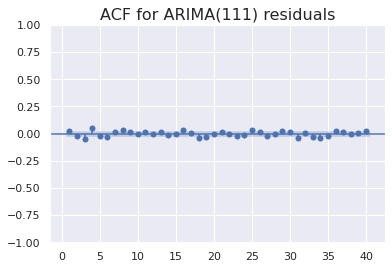

In [12]:
sgt.plot_acf(df['residuals_1_1_1'][1:], zero=False, lags=40)
plt.title("ACF for ARIMA(111) residuals", size=16)
plt.show()

We can observe that the third and fourth lags are highly significant. Incorporating these lags into our model might significantly improve performance.

#### Higher Level ARIMAs

In [13]:
model_1_1_2_arima = ARIMA(df.market_value, order=(1,1,2))
result_1_1_2_arima = model_1_1_2_arima.fit()

model_1_1_3_arima = ARIMA(df.market_value, order=(1,1,3))
result_1_1_3_arima = model_1_1_3_arima.fit()

model_2_1_1_arima = ARIMA(df.market_value, order=(2,1,1))
result_2_1_1_arima = model_2_1_1_arima.fit()

model_3_1_1_arima = ARIMA(df.market_value, order=(3,1,1))
result_3_1_1_arima = model_3_1_1_arima.fit()

model_3_1_2_arima = ARIMA(df.market_value, order=(3,1,2))
result_3_1_2_arima = model_3_1_2_arima.fit()



In [14]:
print(f"ARIMA(1,1,1): \t LL= {result_1_1_1_1_arima.llf} \t AIC = {result_1_1_1_1_arima.aic}")
print(f"ARIMA(1,1,2): \t LL= {result_1_1_2_arima.llf} \t AIC = {result_1_1_2_arima.aic}")
print(f"ARIMA(1,1,3): \t LL= {result_1_1_3_arima.llf} \t AIC = {result_1_1_3_arima.aic}")
print(f"ARIMA(2,1,1): \t LL= {result_2_1_1_arima.llf} \t AIC = {result_2_1_1_arima.aic}")
print(f"ARIMA(3,1,1): \t LL= {result_3_1_1_arima.llf} \t AIC = {result_3_1_1_arima.aic}")
print(f"ARIMA(3,1,2): \t LL= {result_3_1_2_arima.llf} \t AIC = {result_3_1_2_arima.aic}")

ARIMA(1,1,1): 	 LL= -27604.005025656326 	 AIC = 55214.01005131265
ARIMA(1,1,2): 	 LL= -27600.40763254137 	 AIC = 55208.81526508274
ARIMA(1,1,3): 	 LL= -27590.72348194824 	 AIC = 55191.44696389648
ARIMA(2,1,1): 	 LL= -27600.130551053826 	 AIC = 55208.26110210765
ARIMA(3,1,1): 	 LL= -27592.336116474562 	 AIC = 55194.672232949124
ARIMA(3,1,2): 	 LL= -27590.920318054938 	 AIC = 55193.840636109875


The ARIMA(1,1,3) has the highest Log-likelihood and Lowest AIC (Akaike's Information Criterion). That makes this model a top runner. But, ARIMA(1,1,2), and ARIMA(1,1,1) are nested. Lets examine the more to make sure if it is significantly outperforms them. Lets run the LLR test.

In [15]:
print(f"\n ARIMA(1,1,1) and ARIMA(1,1,3) | LLR test p-value = {llr_test(model_1_1_1_arima, model_1_1_3_arima)}")
print(f"\n ARIMA(1,1,2) and ARIMA(1,1,3) | LLR test p-value = {llr_test(model_1_1_2_arima, model_1_1_3_arima, df=2)}")


 ARIMA(1,1,1) and ARIMA(1,1,3) | LLR test p-value = 0.0

 ARIMA(1,1,2) and ARIMA(1,1,3) | LLR test p-value = 0.0


As expected, we get P-value of zero. Hence, The model ARIMA(1,1,3) appears to be best model. Again, we examine the residuals which should resemble white noise.

In [16]:
df['residuals_1_1_3'] = result_1_1_3_arima.resid

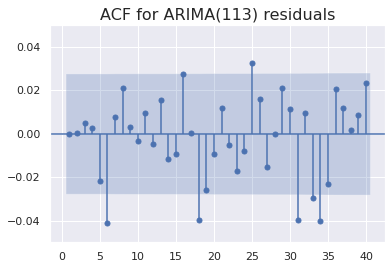

In [17]:
sgt.plot_acf(df['residuals_1_1_3'][1:], zero=False, lags=40)
plt.title("ACF for ARIMA(113) residuals", size=16)
plt.ylim(-0.05, 0.05)
plt.show()

However, the sixth lag is still highly significant. Therefore there might exist a better models which goes back to six lags back. Lets check the ARIMA(6,1,6), ARIMA(6,1,3), ARIMA(5,1,1)

In [18]:
model_5_1_1_arima = ARIMA(df.market_value, order=(5,1,1))
result_5_1_1_arima = model_5_1_1_arima.fit()

model_6_1_3_arima = ARIMA(df.market_value, order=(6,1,3))
result_6_1_3_arima = model_6_1_3_arima.fit()

In [19]:
print(f"ARIMA(1,1,3): \t LL= {result_1_1_3_arima.llf} \t AIC = {result_1_1_3_arima.aic}")
print(f"ARIMA(5,1,1): \t LL= {result_5_1_1_arima.llf} \t AIC = {result_5_1_1_arima.aic}")
print(f"ARIMA(6,1,3): \t LL= {result_6_1_3_arima.llf} \t AIC = {result_6_1_3_arima.aic}")

ARIMA(1,1,3): 	 LL= -27590.72348194824 	 AIC = 55191.44696389648
ARIMA(5,1,1): 	 LL= -27586.844609585853 	 AIC = 55187.689219171705
ARIMA(6,1,3): 	 LL= -27583.85849982001 	 AIC = 55187.71699964002


We can see that the ARIMA(6,1,1) is the best model with highest LL and lowest AIC.

In [20]:
print(f"\n ARIMA(1,1,3) and ARIMA(6,1,3) | LLR test p-value = {llr_test(model_1_1_3_arima, model_6_1_3_arima, df=5)}")
print(f"\n ARIMA(5,1,1) and ARIMA(6,1,3) | LLR test p-value = {llr_test(model_5_1_1_arima, model_6_1_3_arima, df=3)}")


 ARIMA(1,1,3) and ARIMA(6,1,3) | LLR test p-value = 0.017

 ARIMA(5,1,1) and ARIMA(6,1,3) | LLR test p-value = 0.113


In [21]:
df['residuals_5_1_1'] = result_5_1_1_arima.resid

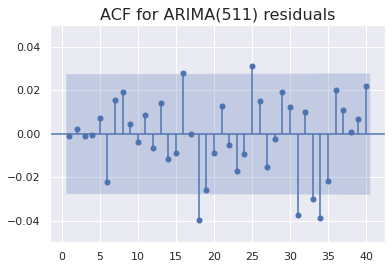

In [22]:
sgt.plot_acf(df['residuals_5_1_1'][1:], zero=False, lags=40)
plt.title("ACF for ARIMA(511) residuals", size=16)
plt.ylim(-0.05, 0.05)
plt.show()

After we presented the graph, we can see that none of the first 15 residuals have significant coefficients. We still see some significant coefficients many lags into the past, but we know that the further back in time we go, the less relevant the values become. On one hand, if we include up to thirty five flags into the model, we will be able to have white noise residuals. On the other hand, it's important to remember that we want this model to be able to predict other time series data as well. 

Hence, after careful consideration, we decided to stick with the ARIMA(5,1,1) as the best estimator for prices

we only rely on integration when our time series doesn't come from a stationary process. Hence, if a single layer of integration accomplishes this, any additional ones are unnecessary.

so how do we go about finding out if the integrated data set is stationary? Well, we can manually create an integrated version of the original Time series and use the augmented Deqi fuller test.

In [23]:
df['delta_prices'] = df.market_value.diff(1)

In [24]:
model_1_1_arima = ARIMA(df.delta_prices[1:], order=(1,0,1))
results_1_1_arima = model_1_1_arima.fit()
results_1_1_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           delta_prices   No. Observations:                 5020
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -27603.666
Date:                Sun, 21 Aug 2022   AIC                          55215.333
Time:                        13:18:38   BIC                          55241.418
Sample:                    01-10-1994   HQIC                         55224.473
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5639      0.753      0.749      0.454      -0.911       2.039
ar.L1          0.7476      0.059     12.673      0.000       0.632       0.863
ma.L1         -0.7937      0.053    -14.871      0.000      -0.898      -0.689
sigma2      3496.6352     41.191     84.888      0.000    3415.902    3577.368
===================================================================================
Ljung-Box (L1) (Q):                   2.64   Jarque-Bera (JB):              3327.38
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               1.90   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

If we compare this table to the simple ARIMA(111) results we got earlier will see that they have identical coefficients and P values, which are what we care about most.

In [25]:
sts.adfuller(df.delta_prices[1:])

(-32.244093495707475,
 0.0,
 5,
 5014,
 {'1%': -3.4316548765428174,
  '5%': -2.8621166146845334,
  '10%': -2.5670769326348926},
 54845.96104221891)

The ADF test justifies the data is stationary. Hence, it is unnecessary to have additional layers of integration. Now, we can recommend to have 1 difference (D) in ARIMA model.

#### ARIMA for Stationary data

ARIMA can estimate the stationary data.

Due to data attrition, The more unnecessary layers we add, the more our model suffers. Data attrition is loosing observations because of the conversion from price to returns, and we loose more data points for each layer of integration. 


**Issues**
- Computationally expensive
- Differentiate the values from zero,
- fail to converge
- Numerical instability
- Hard to interpret 
